# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.20 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
# for i in range(5):                                         # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
import random
import time
import torch

import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque
from ddpg_agent import Agent

from workspace_utils import active_session

In [7]:
# DDPG function
def ddpg(num_episodes=1000, max_t=1000, print_interval=10, actor_weights_name='actor.pth', critic_weights_name='critic.pth'):

    """Deep Deterministic Policy Gradient
    
    Params
    ======
    n_episodes (int): maximum number of training episodes
    max_t (int): maximum number of timesteps per episode
    
    """
    
    max_scores = [] # list of mean scores from each episode
    avgs = [] # list of averages
    best_score = -np.inf
    scores_window = deque(maxlen=100) # mean score from last 100 episodes
    
    for i_episode in range(1, num_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name] # reset environment
        states = env_info.vector_observations # get current state for each observations
        scores = np.zeros(num_agents) # initialize score for each agent
        agent.reset()
        start_time = time.time()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True) # select an action
            env_info = env.step(actions)[brain_name]  # send all actions to tne environment
            next_states = env_info.vector_observations # get next state (for each agent)
            rewards = env_info.rewards # get reward (for each agent)
            dones = env_info.local_done # see if episode finished
            # perform learning step
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)
            states = next_states
            scores += rewards
            if np.any(dones):
                break
        duration = time.time() - start_time
        max_scores.append(np.max(scores)) # save max score for each episode
        scores_window.append(max_scores[-1]) # save max score to window
        avgs.append(np.mean(scores_window)) # save average
        
        if i_episode % print_interval == 0:
            print("\rEpisode {} ({}s)\tMax score: {:.3f}\tAverage: {:.3f}"\
                  .format(i_episode, round(duration), max_scores[-1], avgs[-1]))
        if avgs[-1] >= 0.5:
            print("\nEnvironment solved in {:d} episodes.\tAverage score: {:.3f}"\
                 .format(i_episode, avgs[-1]))
            torch.save(agent.actor_local.state_dict(), actor_weights_name)
            torch.save(agent.critic_local.state_dict(), critic_weights_name)
            break
            
    return max_scores, avgs

In [8]:
# start the training loop
agent = Agent(state_size=state_size, action_size=action_size, random_seed=777)

In [9]:
with active_session():
    scores, avgs = ddpg(actor_weights_name ='actor_tennis.pth', critic_weights_name='critic_tennis.pth')

Episode 10 (4s)	Max score: 0.000	Average: 0.000
Episode 20 (4s)	Max score: 0.000	Average: 0.000
Episode 30 (4s)	Max score: 0.000	Average: 0.000
Episode 40 (4s)	Max score: 0.000	Average: 0.002
Episode 50 (4s)	Max score: 0.000	Average: 0.004
Episode 60 (4s)	Max score: 0.000	Average: 0.011
Episode 70 (25s)	Max score: 0.200	Average: 0.024
Episode 80 (9s)	Max score: 0.100	Average: 0.030
Episode 90 (8s)	Max score: 0.100	Average: 0.037
Episode 100 (8s)	Max score: 0.090	Average: 0.042
Episode 110 (8s)	Max score: 0.100	Average: 0.054
Episode 120 (15s)	Max score: 0.100	Average: 0.066
Episode 130 (9s)	Max score: 0.090	Average: 0.079
Episode 140 (15s)	Max score: 0.100	Average: 0.094
Episode 150 (9s)	Max score: 0.100	Average: 0.109
Episode 160 (19s)	Max score: 0.190	Average: 0.120
Episode 170 (13s)	Max score: 0.100	Average: 0.134
Episode 180 (5s)	Max score: 0.000	Average: 0.143
Episode 190 (18s)	Max score: 0.190	Average: 0.174
Episode 200 (33s)	Max score: 0.300	Average: 0.223
Episode 210 (146s)	Max

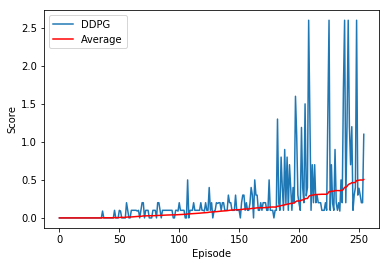

In [10]:
# plot scores across episodes
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='Average')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.legend(loc='upper left');
plt.show()

In [11]:
env.close()